В этом задании мы рассмотрим работу UDpipe с двумя моделями:

* предварительно обученной на SynTagRus [link](https://universaldependencies.org/treebanks/ru_syntagrus/index.html)
* обученной на Taiga [link](https://universaldependencies.org/treebanks/ru_taiga/index.html)

## Подключение необходимых модулей

In [8]:
! pip install -q conllu
! pip install -q graphviz
! pip install -q ufal.udpipe

## Загрузка моделей

In [9]:
!wget -q 'https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-3131/russian-syntagrus-ud-2.5-191206.udpipe'
!wget -q 'https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-3131/russian-taiga-ud-2.5-191206.udpipe'

На этом подготовка материалов завершена, переходим к написанию кода для синтаксического анализа

## Подключение библиотек

In [10]:
import sys

from conllu import parse
from graphviz import Digraph
from ufal.udpipe import Model, Pipeline, ProcessingError

## Настройка работы с моделями

In [11]:
INPUT_FORMAT = "tokenize"
OUTPUT_FORMAT = "conllu"
SYNTAGRUS_MODEL_FILE = "russian-syntagrus-ud-2.5-191206.udpipe"
TAIGA_MODEL_FILE = "russian-taiga-ud-2.5-191206.udpipe"

print("Loading model:" + SYNTAGRUS_MODEL_FILE)
syntagrus_model = Model.load(SYNTAGRUS_MODEL_FILE)
print("Loading done")

print("Loading model:" + TAIGA_MODEL_FILE)
taiga_model = Model.load(TAIGA_MODEL_FILE)
print("Loading done")

Loading model:russian-syntagrus-ud-2.5-191206.udpipe
Loading done
Loading model:russian-taiga-ud-2.5-191206.udpipe
Loading done


## Построение цепочки обработки

Строим цепочку обработки  -- от сырого текста до синтаксического дерева

In [12]:
syntagrus_pipeline = Pipeline(syntagrus_model, INPUT_FORMAT, 
                              Pipeline.DEFAULT, Pipeline.DEFAULT, OUTPUT_FORMAT)
taiga_pipeline = Pipeline(taiga_model, INPUT_FORMAT, 
                          Pipeline.DEFAULT, Pipeline.DEFAULT, OUTPUT_FORMAT)

error = ProcessingError()

Применение собственно цепочки обработки к сырому тексту; вывод в формате CoNLL-U.

In [13]:
def parse_syntax(raw_text, pipeline):
    """ Applying UDPipe """
    text = raw_text.strip()

    # Process data
    processed = pipeline.process(text, error)

    if error.occurred():
        sys.stderr.write("An error occurred when running run_udpipe: ")
        sys.stderr.write(error.message)
        sys.stderr.write("\n")

    return processed

Создадим два разбора, которые и будем сравнивать.

In [14]:
syntag = parse_syntax("Порвались о прибрежные скалы бедные мои зелёные башмачки.", syntagrus_model)
taiga = parse_syntax("Порвались о прибрежные скалы бедные мои зелёные башмачки.", taiga_pipeline)

AttributeError: 'NoneType' object has no attribute 'process'

Разбор предложения в текстовом виде будет выглядеть следующим образом:

In [ ]:
print(taiga)

Понятно, что в таком виде производить расчеты не очень удобно. Для вычисления LAS и UAS сначала представим деревья разбора в виде графов.

## Графововое представление дерева разбора

Методами библиотеки `conllu` превращаем выданный нам udpipe разбор в формате CoNLL-U в дерево, с которым удобно работать.

С помощью стандартного обхода в ширину наполняем рёбрами объект Digraph для последующей визуализации дерева с помощью `graphviz`.

In [ ]:
from conllu import parse
from graphviz import Digraph

def parse_output(conll):
    """
        Preparing the dependency tree for further processing
    """
    sentences = parse(conll)
    return [s.to_tree() for s  in sentences]


class Root(object):
  def __init__(self, child):
    self.token = {"form": "", "id": 0, "deprel": "root"}
    self.children = [child]

def draw_tree(tree):
    """ Drawing a dependency tree for debugging stuff """

    g = Digraph(format='png')

    # a queue for tree traversal
    queue = [Root(tree)]

    while len(queue) > 0:
      
        head = queue.pop()
        head_label = head.token["form"] + " (%d)" % head.token["id"]
        queue.extend(head.children)

        for c in head.children:
            c_label = c.token["form"] + " (%d)" %  c.token["id"]
            g.edge(head_label, c_label, label=c.token["deprel"])

    return g

Построим оба дерева

In [ ]:
str_tree = parse_output(syntag.strip())[0]
taiga_tree = parse_output(taiga.strip())[0]

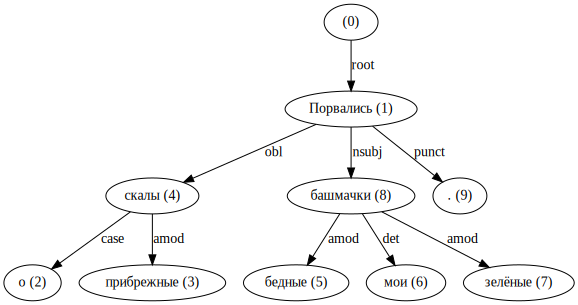

In [ ]:
draw_tree(str_tree)

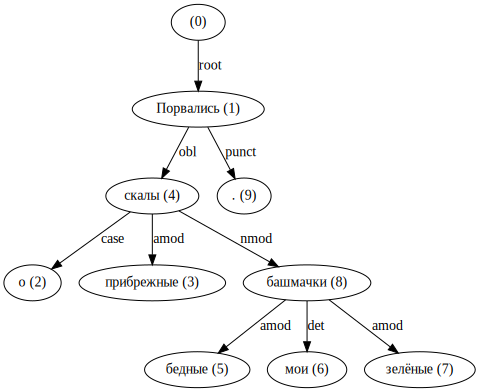

In [ ]:
draw_tree(taiga_tree)

Теперь можно переходить к расчету метрик

## Вычисление LAS и UAS

Для этого набираем множества всех рёбер с метками и без и смотрим на размеры пересечений.

In [ ]:
def edges_sets(tree):
  """ Reading edges encoded as strings """

  edges_labeled = []
  edges_unlabeled = []
  queue = [Root(tree)]
  
  while len(queue) > 0:
    head = queue.pop()
    head_label = head.token["form"] + " (%d)" % head.token["id"]
    queue.extend(head.children)
    
    for c in head.children:
      c_label = c.token["form"] + " (%d)" %  c.token["id"]
      edges_unlabeled.append((head_label, c_label))
      edges_labeled.append((head_label, c_label, c.token["deprel"]))
  
  return set(edges_labeled), set(edges_unlabeled)

In [ ]:
def accuracy(gold, pred):
  gold_labeled, gold_unlabeled = edges_sets(gold)
  pred_labeled, pred_unlabeled = edges_sets(pred)

  return len(gold_labeled.intersection(pred_labeled)) / len(gold_labeled), \
          len(gold_unlabeled.intersection(pred_unlabeled)) / len(gold_unlabeled)

LAS, UAS = accuracy(str_tree, taiga_tree)
"LAS: %.4f UAS: %.4f" % (LAS, UAS)

'LAS: 0.8889 UAS: 0.8889'

Можно заметить, что в первом случае слово <code>башмачки</code> зависит от слова <code>порвались</code>, а во втором -- от слова <code>скалы</code>.
Отдельно хотим напомнить, что таким образом корректно сравнивать парсеры только в том случае, когда токензация полностью совпадает.

## Вычисление глубины дерева

Вычислим глубину дерева, например, для разбора модели taiga (ребро root не учитывается).

Для этого также можно использовать, например, обход в ширину.

In [ ]:
depth = 0
queue = [(taiga_tree, depth)]

while len(queue) > 0:
    head, depth = queue.pop(0)
    queue.extend([(c, depth + 1) for c in head.children])
    #print("checking", head.token["form"])
    
print("Глубина дерева: ", depth)

Глубина дерева:  3
